## Tumor Image Classifier and Explainer
with pre-trained ResNet50 Model <br>
and three explanation algorithms: IG, GradCAM and LRP

##### Note: <br>
This Jupyter Notebook is the associated Python Case Study to the Master's Thesis about XAI in Medicine. The results and outcome of this Notebook are discussed and axplained in the Master's Thesis. <br> The main structure is as follows: <br>
1. Including Packages
2. Data Introduction
3. Load model and classify Images <br>
    3.1 Information about model classifier ResNet50  <br>
    3.2 Images for testing and analyses <br>
    3.3 LRP <br>
4. Model Explainer<br>
    4.1 Integrated Gradients <br>
        - Image Preparation <br>
        - IG Saliency Map <br>
        - Compare Saliency Map with Tumor Borders <br>
        - Create CSV-File for Analysis and Evaluation <br>
        - IG analysis of technical robustness <br>
    4.2 GradCAM <br>
        - Image Preparation <br> 
        - GradCAM Saliency Map <br>
        - Create CSV-File for Analysis and Evaluation<br>
        - GradCAM analysis of technical robustness<br>
        - Guided Backpropagation<br>
        - Guided GradCAM<br>
    4.3 LRP<br>
        - Image Preparation<br>
        - LRP Saliency Map<br>
        - Create CSV-File for Analysis and Evaluation<br>
        - LRP analysis of technical robustness<br>
        - Compare Saliency Map with Tumor Borders<br>
        

##### Info: <br>
Labels: 0. None, 1. Meningioma, 2. Glioma, 3. Pituitary <br>
GitHub Repository for ResNet50 Model Basis: https://github.com/aksh-ai/neuralBlack

### 1. Including Packages 

In [2]:
import pickle
import cv2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
from PIL import Image
from torchvision import transforms, models
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
from torchsummary import summary
import json
from PIL import Image as PilImage
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from omnixai.preprocessing.image import Resize
from omnixai.explainers.vision import IntegratedGradientImage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

### 2. Data Introduction

Example Picture of a Brain Tumor with Type Meningioma (Label 1). <br>
Additionally presenting the shape of the data images.

Bildform: (512, 512, 3)
Label: 1


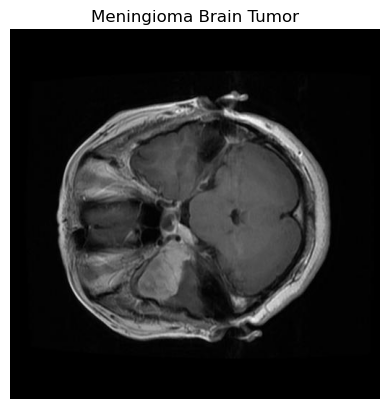

In [68]:
#####################################################################################
### loading trainingdata from pickel-file ###########################################
### preprocessing parts are in detail included in another jupyter notebook ##########
### (where pickle file was set) #####################################################
#####################################################################################

#import pickle
#import cv2
#import numpy as np

# Path to pickle-file with training data
pickle_path = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/training_data.pickle"

# load training data from pickle-file
with open(pickle_path, "rb") as pickle_file:
    training_data = pickle.load(pickle_file)

# To show information/ details from first input image data
first_image = training_data[0][0]  # Image
first_label = training_data[0][1]  # Label

# to show image shape and labels
print("Bildform:", first_image.shape)
print("Label:", first_label)

# display image with matplotlib
plt.imshow(first_image)
plt.title("Meningioma Brain Tumor")
plt.axis("off")
plt.show()


In [69]:
#### Extracting length/ number of training_data
num_training_data = len(training_data)

print(f"Number of training_data: {num_training_data}")

Number of training_data: 3064


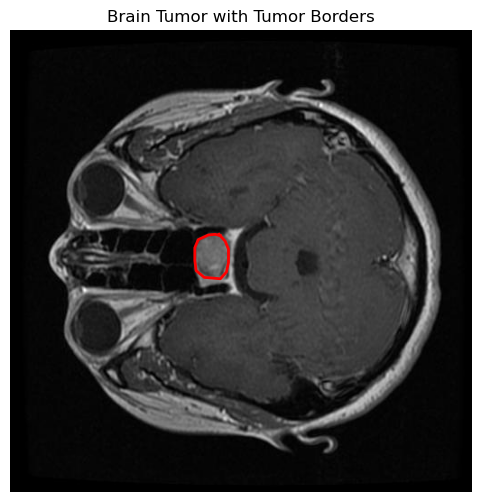

In [70]:
##########################################################################
#### Extracting the Tumor with the Tumor Boardes to visualise Tumor ######
##########################################################################

# Loading the saved pickle list with tumour boundary coordinates
pickle_in = open("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/tumor_borders.pickle", "rb")
border_data = pickle.load(pickle_in)

# set Index for Image to be classified (range 0-3064)
image_index = 999

# load tumor coordinates with border_data
tumor_border = np.array(border_data[image_index])  # convert to NumPy-Array
tumor_border = tumor_border.reshape(-1, 2)  # convert to a two-dimensional array

# load Image
image_path = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/bt_images/{}.jpg".format(image_index + 1)
img = plt.imread(image_path)

# display Image with tumor borders
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.plot(tumor_border[:, 1], tumor_border[:, 0], color='red', linewidth=2)
plt.title('Brain Tumor with Tumor Borders')
plt.axis('off')
plt.show()

In [22]:
#import pickle
#import numpy as np

# save pickle-file in two sepperate arrays

# path to pickle file
pickle_path = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/training_data.pickle"

# load training data
with open(pickle_path, "rb") as pickle_file:
    training_data = pickle.load(pickle_file)

# extract images and lables from training data
images = np.array([item[0] for item in training_data])
labels = np.array([item[1] for item in training_data])

# display shape of arrays
print("Image Shape:", images.shape)
print("Lable Shape:", labels.shape)


Image Shape: (3064, 512, 512, 3)
Lable Shape: (3064,)


Analyse the mat-files and jpg-files as they will be the common input data

In [75]:
#################################################
### Compare the .mat images with the .jpg data ##
### -> check if the lable is the same ###########
#################################################

#from PIL import Image
#import h5py


# Load the test image
img = Image.open('/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/bt_images/1.jpg').convert('RGB')


# Load the test image
#img = PilImage.open('/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/bt_images/1.jpg').convert('RGB')

# Load the .mat file
mat_file_path = '/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/imageData/1.mat'
with h5py.File(mat_file_path, 'r') as mat_file:
    # Access the 'cjdata' dataset
    cjdata = mat_file['cjdata']

    # Access the 'label' key to get the class names
    class_names = cjdata['label'][:]

# Convert class_names to a list of strings
idx2label = [name[0] for name in class_names]

print(idx2label)

[1.0]


In [76]:
#########################################
### print the keys for the .math file ##
########################################

# Load the .mat file
mat_file_path = '/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/imageData/1.mat'
with h5py.File(mat_file_path, 'r') as mat_file:
    print(mat_file.keys())

    
# Load the .mat file
mat_file_path = '/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/imageData/1.mat'
with h5py.File(mat_file_path, 'r') as mat_file:
    # Access the 'cjdata' dataset
    cjdata = mat_file['cjdata']

    # Print the keys within the 'cjdata' dataset
    print(list(cjdata.keys()))

<KeysViewHDF5 ['cjdata']>
['PID', 'image', 'label', 'tumorBorder', 'tumorMask']


### 3. Load the Model and classify Images

The Model Classifier by Akshay Kumaar M. identifies three different tumor types (1. Meningioma, 2. Glioma, 3. Pituitary) and is a finetuned model with an accuracy of 99%. <br> 
The GitHub Repository can be found here: https://github.com/aksh-ai/neuralBlack. <br>
This Model will be used for the case study and therefore, slightly be adjusted if neccessary.

In [3]:
##########################################
### ResNet50 Model Classifier ############
##########################################

#import os
#import torch
#import torch.nn as nn
#import numpy as np
from PIL import Image
#from torchvision import transforms, models

#del input

device_name = "cuda:0:" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

resnet_model = models.resnet50(pretrained=True)

for param in resnet_model.parameters():
    param.requires_grad = True

n_inputs = resnet_model.fc.in_features

resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())

for name, child in resnet_model.named_children():
    for name2, params in child.named_parameters():
        params.requires_grad = True

resnet_model.to(device)

resnet_model.load_state_dict(torch.load('/Users/alinatenne/Documents/Masterarbeit/Pre-Trained_Modell_GitHub/neuralBlack-master/models/bt_resnet50_model.pt', map_location=torch.device('cpu')))



resnet_model.eval()

transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])

LABELS = ['None', 'Meningioma', 'Glioma', 'Pitutary']

img_name = input("Enter path to the image: ")

if not os.path.exists(img_name):
    print("File does not exits. Exiting...\n")
    exit()

img = Image.open(img_name)

img = transform(img)

img = img[None, ...]

with torch.no_grad():
    y_hat = resnet_model.forward(img.to(device))

    predicted = torch.argmax(y_hat.data, dim=1)

    print(LABELS[predicted.data],'\n')
    
#### Testing all possible Tumor Types:
# 1. Meningioma (was detected)
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Meningioma_3064.jpg
# 2. Pituitary (was detected)
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Pituitary_999.jpg
# 3. Glioma (was detected)
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_3041.jpg

# Meningioma - same Input as above
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Meningioma_1.jpg
# Meningioma Source Internet by Osman
# /Users/alinatenne/Downloads/chordoid-meningioma-1.jpg

# Investigate behaviour if all three tumor types are on the picture
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test Images for several Classes in one Picture/all classes/all classes.jpg

# None:
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test Images for several Classes in one Picture/tree.jpg
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test Images for several Classes in one Picture/red.jpg

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Enter path to the image: /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Meningioma_1.jpg
Meningioma 



### 3.1 Information about Model Classifier ResNet50

In [ ]:
# Show the data type of predicted.data = tensor
print(predicted.data)

In [74]:
# Get the input size expected by the model
weight_size = resnet_model.conv1.weight.size()[2:]  # Get the size of the first layer's weight tensor

print("Weight Tensor/ Kernel Size for ResNet-50:", weight_size)

Weight Tensor/ Kernel Size for ResNet-50: torch.Size([7, 7])


In [8]:
# Define a sample input image with the expected size
sample_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels (RGB), 224x224 image size

# Get the output size from the model by passing the sample input
with torch.no_grad():
    resnet_model.eval()
    output = resnet_model(sample_input)

# Get the expected input image size from the shape of the output tensor
expected_input_size = sample_input.shape[2:]

print("Expected input image size for ResNet-50:", expected_input_size)

Expected input image size for ResNet-50: torch.Size([224, 224])


In [9]:
########################################
##### Display Model Summary ############
########################################

#from torchsummary import summary

# Provide the input size for resnet_model
input_size = (3, 224, 224)  # (channels, height, width)

# Print the resnet_model summary
summary(resnet_model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [14]:
import torchinfo
torchinfo.summary(resnet_model, (3, 224, 224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet                                   [1, 3, 224, 224]          [1, 4]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3                         --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 256, 56, 56]          --

In [12]:
#################################################
######## ResNet50 Structure #####################
#################################################

# print model structure, to get layer names and info
print(resnet_model.layer4)

# proove amount of output channels from last convolutional layer
last_conv_layer = resnet_model.layer4[-1].conv3
print("Amount of Output Layers from last convolutional layer:", last_conv_layer.out_channels)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

### 3.2 Images for testing and analyses

In [77]:
### Image Paths

# Paths for testing
image_path = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Meningioma_Internet.jpeg"
img_path1 = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_917.jpg"
image_path2 = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_3041.jpg"
image_path3 = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Pituitary_999.jpg"
img_path_men = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Meningioma_1.jpg"




In [78]:
# Printing Image Size

# Open Image
img = Image.open(img_path_men) # same input as above

# Get Image Size
width, height = img.size
print("Width:", width, "Height:", height)

Width: 512 Height: 512


#### Example Image I:

This example image contains a Meningioma Tumor (Label 1) and is choosen from an open source tumor collection by Mahomed A. Osman. <br>
The image collection can be found here: https://radiopaedia.org/articles/meningioma. <br>
The image has not been part of the model training and is therefore new to the model.

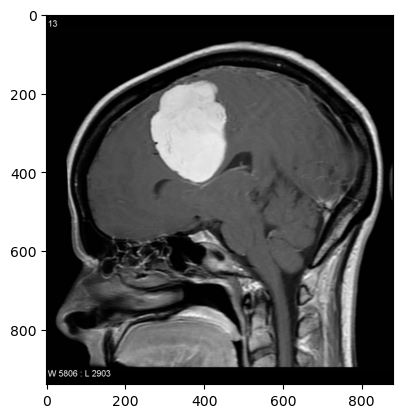

In [79]:
#import matplotlib.pyplot as plt

test_img_1 = Image.open('/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg')
test_img_data = np.asarray(test_img_1)
plt.imshow(test_img_data)


#### Example Image II:

This Example Picture contains a Glioma Tumor (Label 2) and is choosen from the testing data set by Jun Cheng. <br> The dataset can be found here: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427. <br>
As this is an image from the test set, this input is not new to the ResNet50 model.

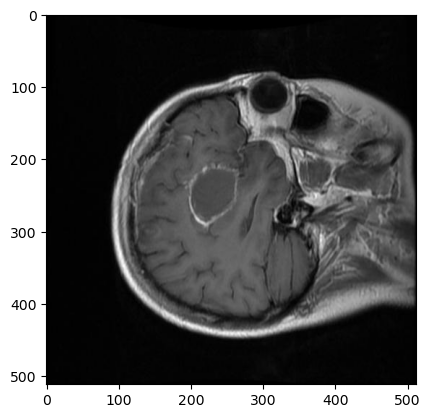

In [84]:
test_img_2 = Image.open("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg")
test_img_data = np.asarray(test_img_2)
plt.imshow(test_img_data)

### 4. Model Explainer:

### 4.1 Integrated Gradients
Source: https://pytorch.org/tutorials/beginner/introyt/captumyt.html
<br> 
##### 4.1.1 Image Preparation

In [94]:
from PIL import Image
# model expectation is 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224), #crop the given tensor image at the center
 transforms.ToTensor()
])
# ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg')
img_2 = Image.open("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg")

transformed_img = transform(img)
transformed_img_2 = transform(img_2)

input = transform_normalize(transformed_img)
#unsqueeze returns a new tensor with a dimension of size one inserted at the #specified position.
input = input.unsqueeze(0)

### same procedure for example image II #####
input_2 = transform_normalize(transformed_img_2)
input_2 = input_2.unsqueeze(0)

In [93]:
################################################
### Check if GPU is available with Pytorch #####
################################################

import torch
torch.cuda.empty_cache()

# Proove if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
# Force to use CPU
device = torch.device("cpu")

# move model and input data to device (!)
resnet_model.to(device)
input = input.to(device)

### same for different input data ####
input_2 = input_2.to(device)

##### 4.1.2 IG Saliency Map

In [91]:
#######################################
### Get Integrated Gradients Map ######
#######################################

with torch.enable_grad():
    # Perform a forward pass to get predictions
    output = resnet_model(input)

    # Get the predicted label index
    pred_label_idx = torch.argmax(output).item()

# Create Integrated Gradients object and get attributes
integrated_gradients = IntegratedGradients(resnet_model)

# Request the algorithm to assign output target
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

#### Example Image I:

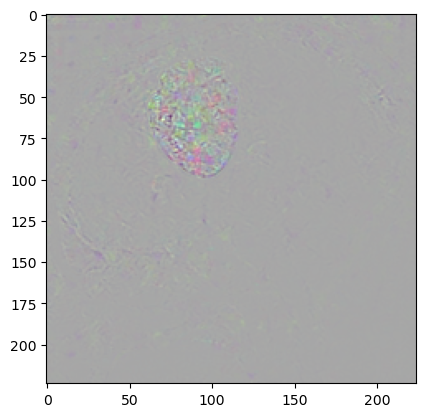

In [88]:
##################################
#### Map/ Display IG Method ######
##################################

# convert attributes to Numpy-Array and transpose to get correct format
heatmap = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

# normalise heatmap to get value range from 0 to 1
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

###### Heatmap with "Meningioma Example Picture I" Image Input ########
# plot heatmap
plt.imshow(heatmap, cmap='viridis', alpha=0.8)
#plt.axis('off')
plt.show()


#### Example Image II:

In [95]:
# Request the algorithm to assign output target
attributions_ig = integrated_gradients.attribute(input_2, target=pred_label_idx, n_steps=200)

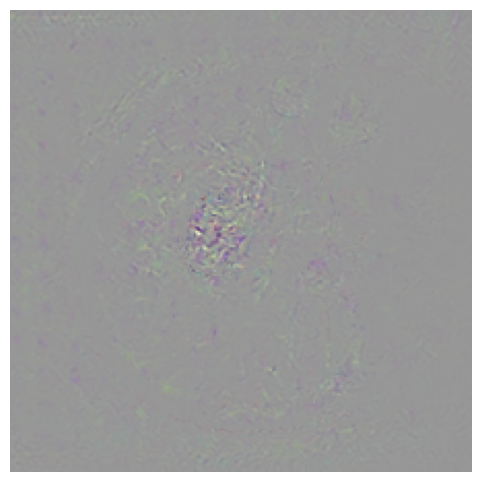

In [96]:
##################################
#### Map/ Display IG Method II ###
##################################

# convert attributes to Numpy-Array and transpose to get correct format
heatmap = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

# normalise heatmap to get value range from 0 to 1
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

###### Heatmap with "Glioma Example Image II" Image Input ########
# plot heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap, cmap='viridis', alpha=0.8)

plt.axis('off')
plt.show()

##### 4.1.3 Compare Saliency Map with Tumor Borders

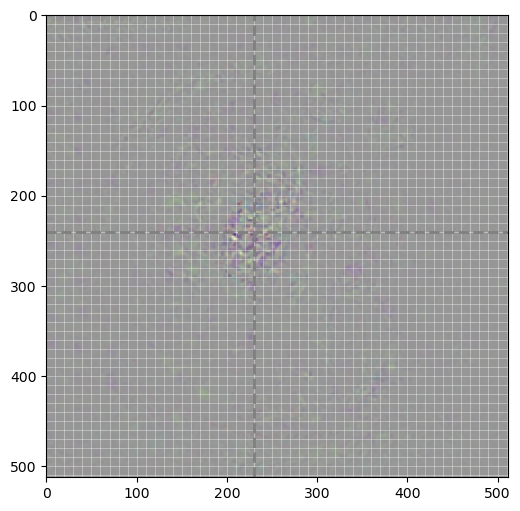

In [64]:
#### plot with lines and coordinates to compare if tumor matches visualisations #####
plt.figure(figsize=(6, 6))

# Heatmap zeichnen
plt.imshow(heatmap, cmap='viridis', alpha=0.8, extent=[0, img.shape[1], img.shape[0], 0])

# Gitternetz zeichnen
plt.hlines(range(0, img.shape[0] + 1, 10), xmin=0, xmax=img.shape[1], color='white', linewidth=0.5, alpha=0.5)
plt.vlines(range(0, img.shape[1] + 1, 10), ymin=0, ymax=img.shape[0], color='white', linewidth=0.5, alpha=0.5)

# Graue Linien bei Y=240 und X=230
plt.axhline(y=240, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=230, color='gray', linestyle='--', linewidth=2)

#plt.axis('off')
plt.show()

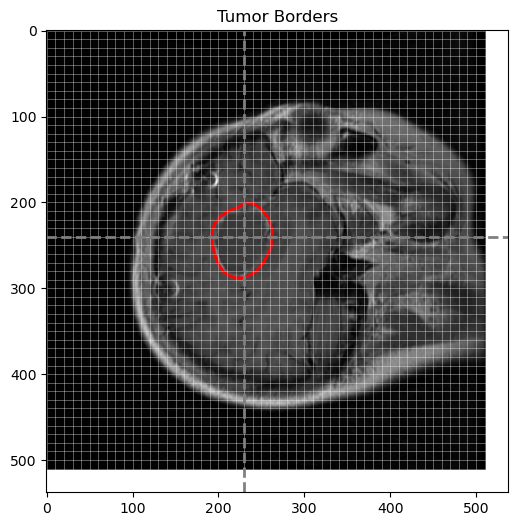

In [97]:
##############################################
## Display Input Image with Glioma Tumor #####
##############################################

image_index = 889

tumor_border = np.array(border_data[image_index])  # convert to NumPy-Array
tumor_border = tumor_border.reshape(-1, 2)  # convert to 2D Array

# load Image Data
image_path = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/bt_images/{}.jpg".format(image_index + 1)
img = plt.imread(image_path)

# Display Tumor Borders
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.plot(tumor_border[:, 1], tumor_border[:, 0], color='red', linewidth=2)

# Draw Grid
plt.hlines(range(0, img.shape[0] + 1, 10), xmin=0, xmax=img.shape[1], color='white', linewidth=0.5, alpha=0.5)
plt.vlines(range(0, img.shape[1] + 1, 10), ymin=0, ymax=img.shape[0], color='white', linewidth=0.5, alpha=0.5)

# Grey Lines at Y=240 and X=230
plt.axhline(y=240, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=230, color='gray', linestyle='--', linewidth=2)


plt.title('Tumor Borders')
#plt.axis('off')
plt.show()

##### 4.1.4 Create CSV-File for Analysis and Evaluation

The .csv File is used to analyse and evaluate the technical robustness of the explanation algorithms. <br>
It is the basis for section 6.1.2 "Technical Robustness and Safety" in the thesis.

In [90]:
##### domain specific evaluation #####
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from captum.attr import IntegratedGradients

# Check if the output directory exists, create if not
output_dir = 'integrated_gradients_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize lists to store results
image_ids = []
labels = []
activations_inside_polygon_list = []
activations_outside_polygon_list = []
mu_values = []

image_index = 1

# Integrated Gradients configuration
integrated_gradients = IntegratedGradients(resnet_model)

# Integrated Gradients loop for each image
for image_data in training_data:
    # Extract image, label, and tumor border
    image = image_data[0]
    label = image_data[1]
    tumor_border = np.array(border_data[image_index - 1])  # Corrected index for tumor border
    tumor_border = tumor_border.reshape(-1, 2)

    # Resize and normalize
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image)

    # Forward pass
    out = resnet_model(input_tensor.unsqueeze(0))

    # Use the label as class_idx
    class_idx = [label.item()]  # Ensure class_idx is a list to match Integrated Gradients' expectations

    # Perform Integrated Gradients
    attributions_ig = integrated_gradients.attribute(input_tensor.unsqueeze(0), target=class_idx, n_steps=200)

    # Calculate activations inside and outside the polygon
    relevance_inside_polygon = attributions_ig.squeeze(0)[torch.from_numpy(np.array(tumor_path.contains_points(tumor_border), dtype=np.float32)).long().unsqueeze(0)].sum()

    # Calculate relevance outside the polygon
    # Convert the boolean array to a tensor with the correct shape
    bool_tensor = torch.tensor(~np.array(tumor_path.contains_points(tumor_border), dtype=bool)).unsqueeze(0).unsqueeze(1).unsqueeze(2)

    print(f"Attributions IG Size: {attributions_ig.size()}")
    print(f"Bool Tensor Size: {bool_tensor.size()}")

    # Resize the tensor to match attributions_ig using interpolate
    bool_tensor = F.interpolate(bool_tensor.float(), size=(attributions_ig.size(2), attributions_ig.size(3)), mode='nearest').bool()

    # Print the size again for verification
    print(f"Resized Bool Tensor Size: {bool_tensor.size()}")

    # Apply the mask and calculate the sum
    relevance_outside_polygon = (attributions_ig * bool_tensor).sum()

    # Calculate mu as the ratio of inside to outside activations
    mu = relevance_inside_polygon / relevance_outside_polygon

    # Append results to lists
    image_ids.append(image_index)
    labels.append(label.item())
    activations_inside_polygon_list.append(relevance_inside_polygon.item())
    activations_outside_polygon_list.append(relevance_outside_polygon.item())
    mu_values.append(mu)

    # Increment the image index
    image_index += 1

# Create a DataFrame from the lists
result_df_ig = pd.DataFrame({
    'id': image_ids,
    'label': labels,
    'activations_inside_polygon': activations_inside_polygon_list,
    'activations_outside_polygon': activations_outside_polygon_list,
    'mu': mu_values
})

# Save the DataFrame to a CSV file
result_csv_path_ig = 'integrated_gradients_results.csv'
result_df_ig.to_csv(result_csv_path_ig, index=False)

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 32])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 31])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 32])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 31])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 40])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 26])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 28])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 41])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 39])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 32])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 41])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 39])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 32])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 48])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 26])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 41])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 39])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 39])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 34])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 31])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 45])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 35])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 41])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 39])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 28])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 26])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 37])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 35])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 26])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 49])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 49])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 67])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 33])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 47])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 40])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 43])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 26])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 44])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 29])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 10])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 10])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 38])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 10])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 10])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 39])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 36])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 35])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 7])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 33])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 50])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 35])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 37])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 30])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 35])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 28])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 32])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 28])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 26])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 34])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 23])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 30])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 37])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 49])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 32])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 30])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 25])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 30])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 28])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 31])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 21])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 20])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 9])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([2

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 27])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 36])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 24])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 38])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 33])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 7])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([2

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 10])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 8])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([2

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 18])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 17])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 13])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 11])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 10])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 15])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 14])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 10])
Resized Bool Tensor Size: torch.Size

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 32])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 16])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tenso

Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 12])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 22])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 19])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([

Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 5])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([200, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([200, 2048, 7, 7])
Attributions IG Size: torch.Size([1, 3, 224, 224])
Bool Tensor Size: torch.Size([1, 1, 1, 8])
Resized Bool Tensor Size: torch.Size([1, 1, 224, 224])


In [97]:
import pandas as pd
import ast
# As the csv-file only contains the mu-value as a tensor, another variable "mu_value" is defined to provide the concrete float value
# Load the existing CSV file
csv_path = 'integrated_gradients_results.csv'
df = pd.read_csv(csv_path)

# Calculate the Mu value individually for each entry, handling division by zero
df['mu_value'] = df.apply(lambda row: row['activations_inside_polygon'] / row['activations_outside_polygon'] if row['activations_outside_polygon'] != 0 else None, axis=1)

# Save the updated DataFrame to the CSV file
df.to_csv(csv_path, index=False)


In [48]:
import pandas as pd
###### ATTENTION: amounts are taken from the activations here, as otherwise the mu_value is not between 0 and 1
###### The results have not been changed by this! Only the value range of the mu_value has been changed
# read file
result_df = pd.read_csv('integrated_gradients_results.csv')

# Amount function for attribution values
result_df['activations_inside_polygon'] = result_df['activations_inside_polygon'].abs()
result_df['activations_outside_polygon'] = result_df['activations_outside_polygon'].abs()

# Calculate mu_value with the updated values
result_df['mu_value'] = result_df['activations_inside_polygon'] / (result_df['activations_inside_polygon'] + result_df['activations_outside_polygon'])

# Save the updated DataFrame in the existing CSV file to overwrite it
result_csv_path = 'integrated_gradients_results.csv'
result_df.to_csv(result_csv_path, index=False)


In [49]:
# Display .csv-File for IG
result_df

id  label  activations_inside_polygon  activations_outside_polygon  \
0        1      1                  326.589014                    10.562631   
1        2      1                   31.842571                    10.260810   
2        3      1                    1.502411                     5.929522   
3        4      1                   30.003222                    14.877315   
4        5      1                   55.550384                    15.519084   
...    ...    ...                         ...                          ...   
3059  3060      2                  245.054271                    28.642030   
3060  3061      2                  177.188565                    19.028902   
3061  3062      2                  138.241294                    23.795052   
3062  3063      1                   41.865348                    14.410904   
3063  3064      1                   17.204919                    14.234773   

                                        mu  mu_value  
0     tensor(30.9193, dtype=torch.float64)  0.968671  
1      tensor(3.1033, dtype=torch.float64)  0.756295  
2      tensor(0.2534, dtype=torch.float64)  0.202156  
3     tensor(-2.0167, dtype=torch.float64)  0.668513  
4      tensor(3.5795, dtype=torch.float64)  0.781635  
...                                    ...       ...  
3059   tensor(8.5558, dtype=torch.float64)  0.895351  
3060   tensor(9.3115, dtype=torch.float64)  0.903021  
3061   tensor(5.8097, dtype=torch.float64)  0.853150  
3062   tensor(2.9051, dtype=torch.float64)  0.743926  
3063   tensor(1.2087, dtype=torch.float64)  0.547236  

[3064 rows x 6 columns]

##### 4.1.5 IG analysis of technical robustness

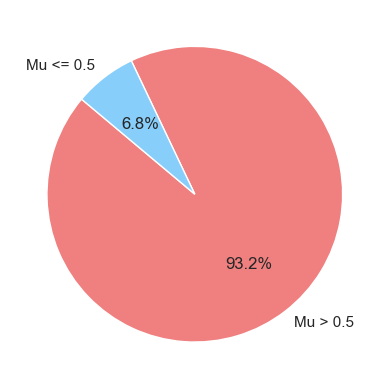

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# read file
result_df = pd.read_csv('integrated_gradients_results.csv')

# Count the number of Mu values above and below 0.5
mu_above_0_5 = (result_df['mu_value'] > 0.5).sum()
mu_below_0_5 = (result_df['mu_value'] <= 0.5).sum()

# Create a pie chart
labels = ['Mu > 0.5', 'Mu <= 0.5']
sizes = [mu_above_0_5, mu_below_0_5]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
#plt.title('Distribution of Mu Values')
plt.show()

In [65]:
torch.cuda.empty_cache()

### 4.2 GradCAM
Source: https://github.com/frgfm/torch-cam

##### 4.2.1 Image Preparation

In [7]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
# Get your input
img = read_image("/Users/alinatenne/Documents/Masterarbeit/Images_Thesis/Chapter XAI Tools/chordoid-meningioma-1.jpg")
img_2 = read_image("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg")

# Preprocess input
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

input_tensor_2 = normalize(resize(img_2, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


###### 4.2.2 GradCAM Saliency Map

In [5]:
from torchcam.methods import SmoothGradCAMpp
model = resnet_model

# choose target layer
target_layer = model.layer1[-1]
#target_layer = model.layer2[-1]
#target_layer = model.layer4[-1]
#target_layer = model.layer4[-1].conv3


cam_extractor = SmoothGradCAMpp(model, target_layer)

#### Example Image I:

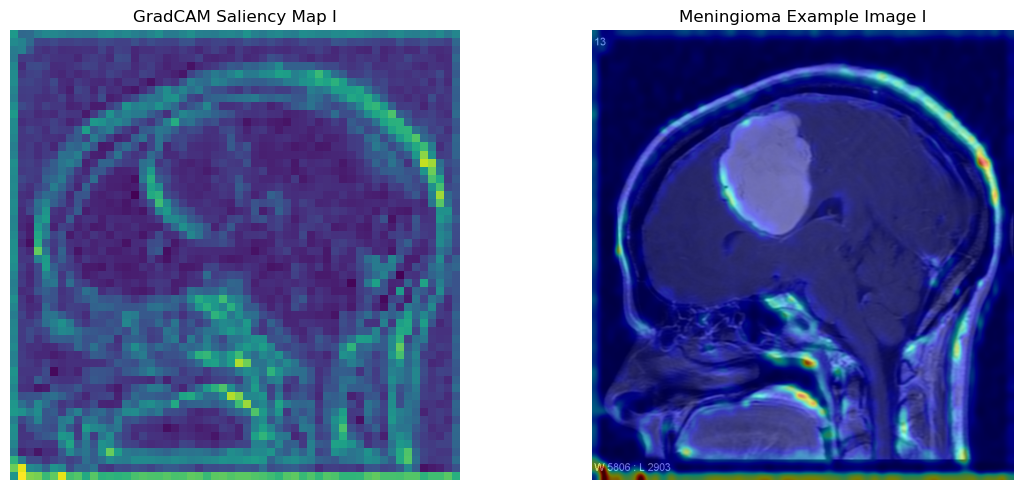

In [9]:
####################################
#### Map/ Display GradCAM Method ###
####################################

from torchcam.utils import overlay_mask
out = model(input_tensor.unsqueeze(0))

activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the activation map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(activation_map[0].squeeze(0).numpy())
plt.title('GradCAM Saliency Map I')
plt.axis('off')  # Turn off axes

# Plot the overlaid image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(result)
plt.title('Meningioma Example Image I')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

#### Example Image II:

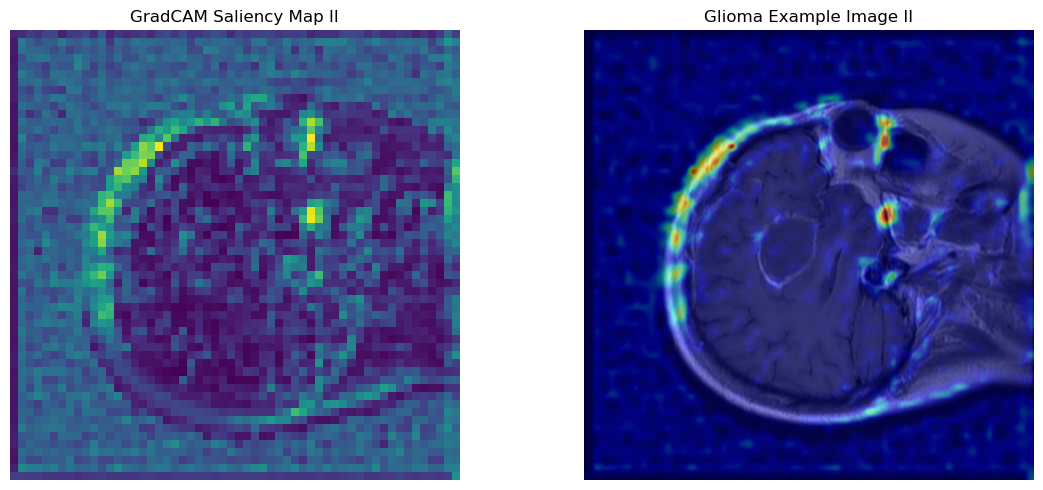

In [10]:
#######################################
#### Map/ Display GradCAM Method II ###
#######################################

out = model(input_tensor_2.unsqueeze(0))

activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img_2), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display it
# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the activation map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(activation_map[0].squeeze(0).numpy())
plt.title('GradCAM Saliency Map II')
plt.axis('off')  # Turn off axes

# Plot the overlaid image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(result)
plt.title('Glioma Example Image II')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

##### 4.2.3 Create CSV-File for Analysis and Evaluation

In [26]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from torchcam.methods import SmoothGradCAMpp
from matplotlib.path import Path
from torchcam.utils import overlay_mask

# Create a polygon object from the tumor boundaries
tumor_path = Path(tumor_border)

# Check if the output directory exists, create if not
output_dir = 'gradcam_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize lists to store results
image_ids = []
activations_inside_polygon_list = []
activations_outside_polygon_list = []
mu_values = []

image_index = 1

# GradCAM configuration
target_layer = resnet_model.layer4[-1]

# GradCAM extractor
cam_extractor = SmoothGradCAMpp(resnet_model, target_layer)

# GradCAM loop for each image
for image_data in training_data:
    # Extract image, label, and tumor border
    image = image_data[0]
    label = image_data[1]
    tumor_border = np.array(border_data[image_index - 1])  # Corrected index for tumor border
    tumor_border = tumor_border.reshape(-1, 2)

    # Resize and normalize
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image)

    # Forward pass
    out = resnet_model(input_tensor.unsqueeze(0))

    # Use the label as class_idx
    class_idx = [label.item()]  # Ensure class_idx is a list to match GradCAM's expectations

    # Perform GradCAM
    activation_maps = cam_extractor(class_idx, out)

    for i, activation_map in enumerate(activation_maps):
        # Diagnose the sizes
        print(f"Activation Map Size: {activation_map.shape}")
        print(f"Tumor Path Contains Points Size: {tumor_path.contains_points(tumor_border).shape}")

        # Save GradCAM result
        result_path = os.path.join(output_dir, f'gradcam_result_{image_index}_map_{i}.png')
        result = overlay_mask(to_pil_image(image), to_pil_image(activation_map, mode='F'), alpha=0.5)
        result.save(result_path)

        # Create a mask with the same size as the activation map
        mask = torch.zeros_like(activation_map[0, 0])

        # Set points inside the tumor to 1
        tumor_mask = tumor_path.contains_points(tumor_border)
        print(f"Tumor Mask Size: {tumor_mask.shape}")

        # Resize tumor_mask to match the size of mask
        resized_tumor_mask = torch.zeros_like(mask)

        if len(tumor_mask) >= mask.shape[0]:
            resized_tumor_mask[:mask.shape[0]] = torch.tensor(tumor_mask[:mask.shape[0]], dtype=torch.float32)
        else:
            resized_tumor_mask[:len(tumor_mask)] = torch.tensor(tumor_mask, dtype=torch.float32)

        # Calculate the sum of relevant activations inside and outside the tumor
        relevance_inside_polygon = (activation_map * resized_tumor_mask).sum().item()
        relevance_outside_polygon = (activation_map * (1 - resized_tumor_mask)).sum().item()
        
        # Calculate mu as the ratio of inside to outside activations
        mu = relevance_inside_polygon / relevance_outside_polygon


        # Append results to lists
        image_ids.append(image_index)
        activations_inside_polygon_list.append(relevance_inside_polygon)
        activations_outside_polygon_list.append(relevance_outside_polygon)
        mu_values.append(mu)

    # Increment the image index
    image_index += 1



# Create a DataFrame from the lists
result_df = pd.DataFrame({
    'id': image_ids,
    'activations_inside_polygon': activations_inside_polygon_list,
    'activations_outside_polygon': activations_outside_polygon_list,
    'mu': mu_values
})

# Save the DataFrame to a CSV file
result_csv_path = 'gradcam_results.csv'
result_df.to_csv(result_csv_path, index=False)


Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (19,)
Tumor Mask Size: (19,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (32,)
Tumor Mask Size: (32,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (29,)
Tumor Mask Size: (29,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (31,)
Tumor Mask Size: (31,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (16,)
Tumor Mask Size: (16,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (16,)
Tumor Mask Size: (16,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (16,)
Tumor Mask Size: (16,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (20,)
Tumor Mask Size: (20,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (15,)
Tumor Mask Size: (15,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path C

Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (46,)
Tumor Mask Size: (46,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (39,)
Tumor Mask Size: (39,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (53,)
Tumor Mask Size: (53,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (57,)
Tumor Mask Size: (57,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (41,)
Tumor Mask Size: (41,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (28,)
Tumor Mask Size: (28,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (28,)
Tumor Mask Size: (28,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (22,)
Tumor Mask Size: (22,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (29,)
Tumor Mask Size: (29,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path C

Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (43,)
Tumor Mask Size: (43,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (24,)
Tumor Mask Size: (24,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (25,)
Tumor Mask Size: (25,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (28,)
Tumor Mask Size: (28,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (12,)
Tumor Mask Size: (12,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (25,)
Tumor Mask Size: (25,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (31,)
Tumor Mask Size: (31,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (35,)
Tumor Mask Size: (35,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path Contains Points Size: (27,)
Tumor Mask Size: (27,)
Activation Map Size: torch.Size([1, 7, 7])
Tumor Path C

ZeroDivisionError: float division by zero

In [27]:
import pandas as pd

# Read the existing CSV file
existing_csv_path = 'gradcam_results.csv'
existing_df = pd.read_csv(existing_csv_path)

# Initialize a list to store labels
labels_list = []

# Iterate over training_data and extract labels
for image_data in training_data:
    label = image_data[1]
    labels_list.append(label)

# Add the 'label' column to the DataFrame
existing_df['label'] = labels_list

# Save the updated DataFrame back to the CSV file
existing_df.to_csv(existing_csv_path, index=False)


In [28]:
import pandas as pd

# Read the existing CSV file
result_df = pd.read_csv('gradcam_results.csv')

# Replace the previous Mu value with "activations inside polygon / total activations"
result_df['mu_value'] = result_df['activations_inside_polygon'] / (result_df['activations_inside_polygon'] + result_df['activations_outside_polygon'])

# Save the updated DataFrame in the existing CSV file to overwrite it
result_df.to_csv('gradcam_results.csv', index=False)


##### 4.2.4 GradCAM analysis of technical robustness

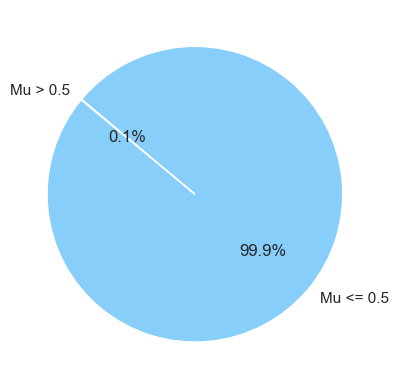

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.read_csv('gradcam_results.csv')

# Count the number of Mu values above and below 0.5
mu_above_0_5 = (result_df['mu_value'] > 0.5).sum()
mu_below_0_5 = (result_df['mu_value'] <= 0.5).sum()

# Create a pie chart
labels = ['Mu > 0.5', 'Mu <= 0.5']
sizes = [mu_above_0_5, mu_below_0_5]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
#plt.title('Distribution of Mu Values')
plt.show()

##### 4.2.5 Guided Backpropagation
##### Note: <b>
    Output is used for figure in the Master's Thesis, to explain the GradCAM algorithm.
Source: https://captum.ai/api/guided_backprop.html#:~:text=Guided%20backpropagation%20computes%20the%20gradient,non%2Dnegative%20gradients%20are%20backpropagated.&text=Warning%3A%20Ensure%20that%20all%20ReLU,performed%20using%20a%20module%20(nn.

In [43]:
# Get Input (Meningioma Tumor Image from Internet Source)
img = read_image("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Meningioma_Internet.jpeg")

# Preprocess Image
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [44]:
from captum.attr import GuidedBackprop
input_tensor = input_tensor.unsqueeze(0)  # adding Batch-Dimension

#gbp = GuidedBackprop(model)
gbp = GuidedBackprop(resnet_model)
# Computes Guided Backprop attribution scores for class 1. (Meningioma)
attribution = gbp.attribute(input_tensor, target=1)

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])


Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


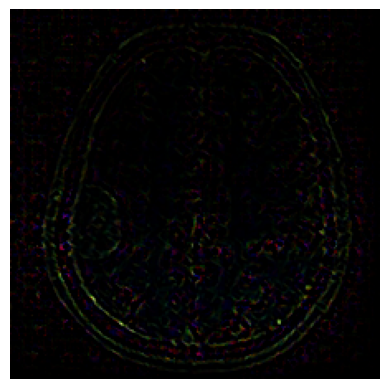

In [46]:
#######################
### Display Image #####
#######################

# Convert attributions to image
attribution_image = attribution.squeeze(0).permute(1, 2, 0).detach().numpy()

# display image
plt.imshow(attribution_image, cmap='jet')  # add colormap
plt.axis('off')
plt.show()

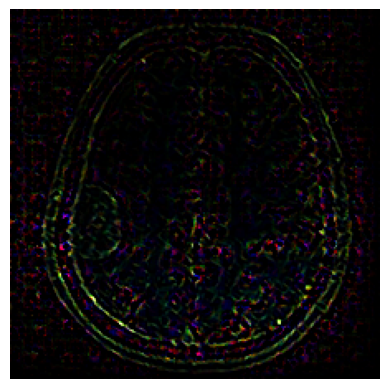

In [48]:
# Adjust brightness because image is very dark -> now values will be highlighted
brightness_factor = 2.0  # adjust factor for more/ less bightness
adjusted_attribution = np.clip(attribution_image * brightness_factor, 0, 1)

# show image
plt.imshow(adjusted_attribution, cmap='jet')
plt.axis('off')
plt.show()

##### 4.2.6 Guided Grad CAM
##### Note: <b>
    Output is used for figure in the Master's Thesis, to explain the GradCAM algorithm.
    
Source: https://captum.ai/api/guided_grad_cam.html

In [49]:
from captum.attr import GuidedGradCam

guided_gc = GuidedGradCam(model, model.layer1[-1])

# Computes guided GradCAM attributions for class 1. (Meningioma)
# attribution size matches input size
attribution = guided_gc.attribute(input_tensor, 1)

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])


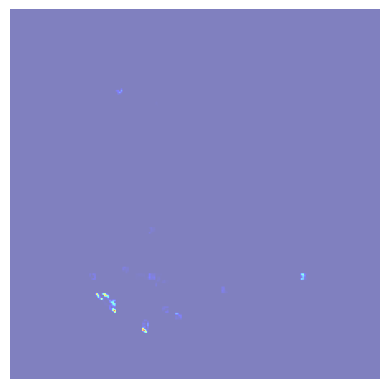

In [50]:
#######################
### Display Image #####
#######################

# convert attributes to image
attribution_np = attribution.squeeze(0).detach().cpu().numpy()  # Detach-Tensor and convert to NumPy-Array
attribution_np = np.maximum(0, attribution_np)  # keep only positive values
attribution_np = attribution_np.mean(axis=0)  # remove channels and change to grey-scale image

# show attributions as single image
plt.imshow(attribution_np, cmap='jet', alpha=0.5)  # set 'jet' Colormap for attributions
plt.axis('off')
plt.show()


#### 4.3 LRP
Source: https://github.com/chr5tphr/zennit

##### 4.3.1 Image Preparation

In [11]:
image_path_2 = '/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg'
image_path = '/Users/alinatenne/Documents/Masterarbeit/Images_Thesis/Chapter XAI Tools/chordoid-meningioma-1.jpg'
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # add Batch-Dimension

image_2 = Image.open(image_path_2)
image_tensor_2 = transform(image_2).unsqueeze(0)  # add Batch-Dimension

##### 4.3.2 LRP Saliency Map

In [12]:
# Amount of classes (0 to 3) (None, M, P, G)
num_classes = 4

# Canonizers und Composite
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

#### Example Image I:

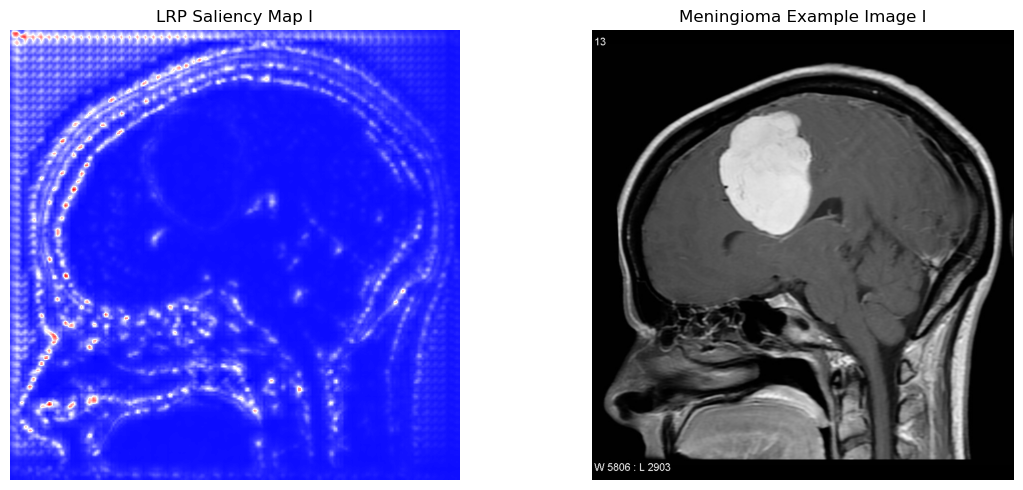

In [13]:
####################################
#### Map/ Display LRP Method #######
####################################

# Attribution with Gradient
with Gradient(model=resnet_model, composite=composite) as attributor:
    out, relevance = attributor(image_tensor, torch.eye(num_classes)[[1]])  # set prediction class (!)

# relevanz map transformed to grey-scaled image
relevance_map = relevance.squeeze().cpu().numpy()  # Relevance map with correct formation
relevance_map = relevance_map.mean(axis=0)  # Mean of color channels
relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())  # Normalization to [0, 1]

# Load the comparison image
image_path = '/Users/alinatenne/Documents/Masterarbeit/Images_Thesis/Chapter XAI Tools/chordoid-meningioma-1.jpg'
comparison_image = plt.imread(image_path)

# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the relevance map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(relevance_map, cmap='bwr', interpolation='bilinear') # Blue-white-red color map
plt.title('LRP Saliency Map I')
plt.axis('off')  # Turn off axes

# Plot the comparison image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(comparison_image)
plt.title('Meningioma Example Image I')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

#### Example Image II:

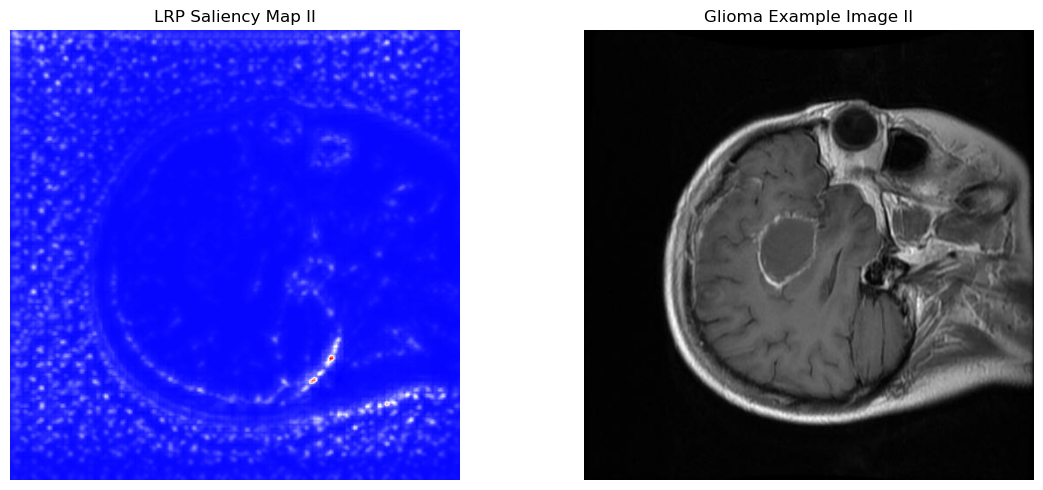

In [14]:
####################################
#### Map/ Display LRP Method II ####
####################################

# Attribution with Gradient
with Gradient(model=resnet_model, composite=composite) as attributor:
    out, relevance = attributor(image_tensor_2, torch.eye(num_classes)[[2]])  # set prediction class (!)

# relevanz map transformed to grey-scaled image
relevance_map = relevance.squeeze().cpu().numpy()  # Relevance map with correct formation
relevance_map = relevance_map.mean(axis=0)  # Mean of color channels
relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())  # Normalization to [0, 1]

# Load the comparison image
image_path = '/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg'
comparison_image = plt.imread(image_path)

# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the relevance map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(relevance_map, cmap='bwr', interpolation='bilinear') # Blue-white-red color map
plt.title('LRP Saliency Map II')
plt.axis('off')  # Turn off axes

# Plot the comparison image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(comparison_image)
plt.title('Glioma Example Image II')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()


##### 4.3.3 Create CSV-File for Analysis and Evaluation

In [98]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Initialize empty lists for results
image_labels = []
activations_inside_polygon_list = []
activations_outside_polygon_list = []
mu_values = []

# LRP-Attribution and evaluation for each image
index = 1  # Start index at 1
for image_data in training_data:
    # Extract image, label, and tumor border
    image = image_data[0]
    label = image_data[1]
    tumor_border = np.array(border_data[index - 1])  # Corrected index for tumor border
    tumor_border = tumor_border.reshape(-1, 2)

    # Perform transformations on the image
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(Image.fromarray(image)).unsqueeze(0)  # Convert from numpy array to PIL Image and add batch dimension

    # Number of classes (0 to 3) (None, M, P, G)
    num_classes = 4

    # Canonizers and Composite
    canonizers = [SequentialMergeBatchNorm()]
    composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

    # Attribution with Gradient
    with Gradient(model=resnet_model, composite=composite) as attributor:
        out, relevance = attributor(image_tensor, torch.eye(num_classes)[[label]])  # Set the predicted class (!)

    # Convert relevance map to grayscale image
    relevance_map = relevance.squeeze().cpu().numpy()  # Correctly shaped relevance map
    relevance_map = relevance_map.mean(axis=0)  # Mean of color channels
    relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())

    # Create a Polygon object from tumor borders
    tumor_path = Path(tumor_border)

    # Extract height and width of the relevance map
    height, width = relevance_map.shape[:2]

    # Round coordinates of the polygon to the nearest integer pixel values
    rounded_tumor_border = np.column_stack((np.clip(np.round(tumor_border[:, 1]), 0, width - 1).astype(int), np.clip(np.round(tumor_border[:, 0]), 0, height - 1).astype(int)))

    # Extract relevant values inside the rounded polygon
    relevance_inside_polygon = relevance_map[rounded_tumor_border[:, 1], rounded_tumor_border[:, 0]]

    # Extract relevant values outside the rounded polygon
    relevance_outside_polygon = np.delete(relevance_map, rounded_tumor_border[:, 0], axis=1).mean(axis=1)

    # Count the number of activations inside and outside the polygon
    activations_inside_polygon = np.sum(relevance_inside_polygon)
    activations_outside_polygon = np.sum(relevance_outside_polygon)

    # Calculate mu as the ratio of inside to outside activations
    mu = activations_inside_polygon / activations_outside_polygon

    # Add results to lists
    image_labels.append(label)
    activations_inside_polygon_list.append(activations_inside_polygon)
    activations_outside_polygon_list.append(activations_outside_polygon)
    mu_values.append(mu)

    # Increment the index for the next iteration
    index += 1

# Create a Pandas DataFrame from the lists
result_df = pd.DataFrame({
    'Label': image_labels,
    'Activations Inside Polygon': activations_inside_polygon_list,
    'Activations Outside Polygon': activations_outside_polygon_list,
    'mu_value': mu_values
})

# Save the DataFrame to a CSV file
result_df.to_csv('lrp_results.csv', index=False)

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Act

In [2]:
import pandas as pd
#### Calculation for mu-value

result_df = pd.read_csv('lrp_results.csv')

# Replace the previous Mu value with "activations inside polygon / total activations"
result_df['mu_value'] = result_df['Activations Inside Polygon'] / (result_df['Activations Inside Polygon'] + result_df['Activations Outside Polygon'])

# Save the updated DataFrame in the existing CSV file to overwrite it
result_df.to_csv('lrp_results.csv', index=False)

##### 4.3.4 LRP analysis of technical robustness

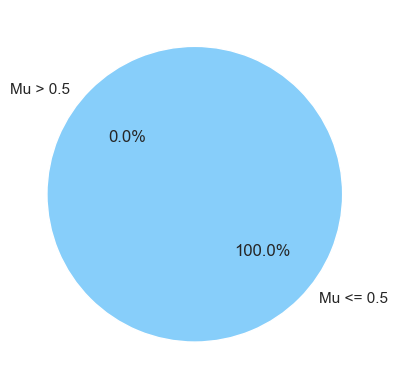

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.read_csv('lrp_results.csv')

# Count the number of Mu values above and below 0.5
mu_above_0_5 = (result_df['mu_value'] > 0.5).sum()
mu_below_0_5 = (result_df['mu_value'] <= 0.5).sum()

# Create Pie Chart
labels = ['Mu > 0.5', 'Mu <= 0.5']
sizes = [mu_above_0_5, mu_below_0_5]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
#plt.title('Distribution of Mu Values')
plt.show()


##### 4.3.5 Compare Saliency Map with Tumor Borders

In [111]:
import pandas as pd

# Read the CSV file with header
df = pd.read_csv('lrp_results.csv')

# Add an 'ID' column to the DataFrame
df['ID'] = range(1, len(df) + 1)

# Find the row with the highest aggregated activations inside the polygon
max_activation_row = df.loc[df['Activations Inside Polygon'].idxmax()]

# Get the image index from the selected row
selected_image_index = int(max_activation_row['ID'])

# Load the corresponding image and tumor borders
image_path = f'/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/bt_images/{selected_image_index}.jpg'
tumor_border = np.array(border_data[selected_image_index])
tumor_border = tumor_border.reshape(-1, 2)
print(selected_image_index)


272


Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Forward hook running...
Activations size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 2048, 7, 7])


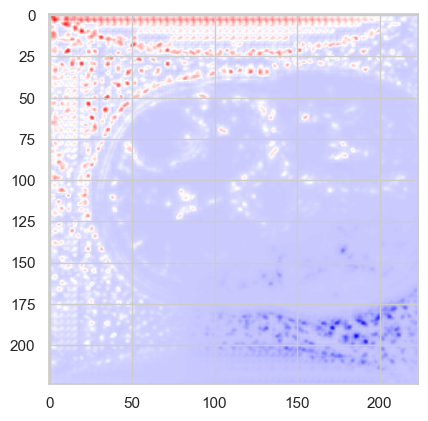

In [117]:
###### Compute Heatmap with selected image index (image with max activations)
image_path_max = f'/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/bt_images/{selected_image_index}.jpg'
image = Image.open(image_path_max)
image_tensor = transform(image).unsqueeze(0)

with Gradient(model=resnet_model, composite=composite) as attributor:
    out, relevance = attributor(image_tensor, torch.eye(num_classes)[[1]])  # class label 1 for Meningioma

relevance_map = relevance.squeeze().cpu().numpy()
relevance_map = relevance_map.mean(axis=0)
relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())
plt.imshow(relevance_map, cmap='bwr', interpolation='bilinear')
plt.show()

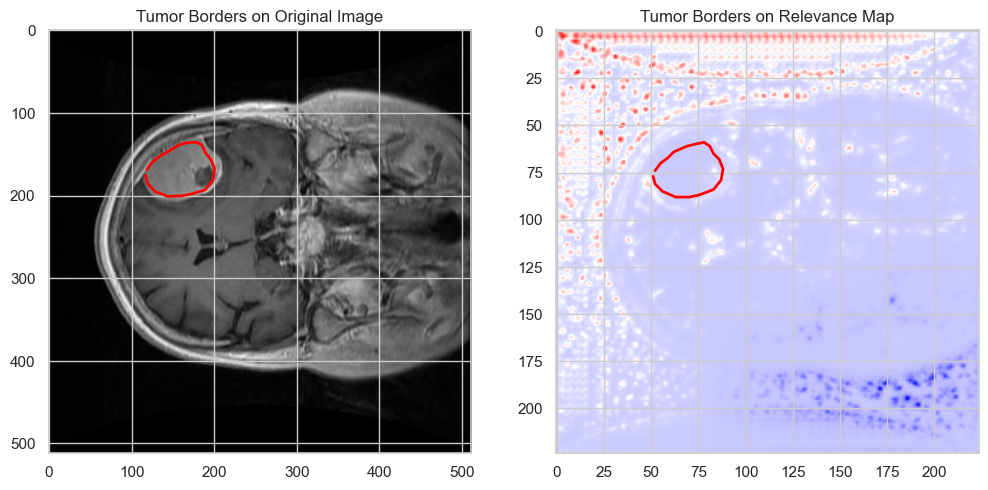

In [127]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.path import Path

original_image_width = 512
original_image_height = 512


# load Image
img = Image.open(image_path)

# Extract the tumour boundary coordinates for the selected image
tumor_border = np.array(border_data[selected_image_index])
tumor_border = tumor_border.reshape(-1, 2)

# Create a polygon object from the tumor boundaries
tumor_path = Path(tumor_border)

# Extract the height and width of the relevance map
height, width = relevance_map.shape[:2]

# Round the coordinates of the polygon to the nearest integer pixel values
rounded_tumor_border = np.column_stack((
    np.clip(np.round(tumor_border[:, 1] * (width / original_image_width)), 0, width - 1).astype(int),
    np.clip(np.round(tumor_border[:, 0] * (height / original_image_height)), 0, height - 1).astype(int)
))

# Plot tumor borders on the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.plot(tumor_border[:, 1], tumor_border[:, 0], color='red', linewidth=2)
plt.title('Tumor Borders on Original Image')

# Plot tumor borders on the relevanz map
plt.subplot(1, 2, 2)
plt.imshow(relevance_map, cmap='bwr', interpolation='bilinear')
plt.plot(rounded_tumor_border[:, 0], rounded_tumor_border[:, 1], color='red', linewidth=2)
plt.title('Tumor Borders on Relevance Map')

plt.show()


In [ ]:
!mercury run
#cd /Users/alinatenne/Documents/Masterarbeit/Versuch_Webanwendung/fastapi_Image_Upload
#(base) alinatenne@Air-von-Alina fastapi_Image_Upload % uvicorn main:app --reload

                            

     _ __ ___   ___ _ __ ___ _   _ _ __ _   _ 
    | '_ ` _ \ / _ \ '__/ __| | | | '__| | | |
    | | | | | |  __/ | | (__| |_| | |  | |_| |
    |_| |_| |_|\___|_|  \___|\__,_|_|   \__, |
                                         __/ |
                                        |___/ 
        
Version: 2.3.7
The notebook GradCAM_polishing.ipynb will be updated
Successfully updated a notebook (id:7)
The notebook CLASSIC_ResNet50_Tumor_Classifier_and_Explainer.ipynb will be updated
Successfully updated a notebook (id:8)
The notebook brain_tumor_dataset_preparation.ipynb will be updated
Successfully updated a notebook (id:9)
The notebook OLD_ResNet50_Tumor_Classifier_and_Explainer.ipynb will be updated
Successfully updated a notebook (id:10)
The notebook GradCAM_ResNet50.ipynb will be updated
Successfully updated a notebook (id:11)
The notebook torch_brain_tumor_classifier.ipynb will be updated
Successfully updated a notebook (id:12)
The notebook ResNet50_Tumor_C